# 华东医药股吧帖子标题研究

## 代码前准备

### 导入所需要的包

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

import os
import re
import jieba as jb
from time import time
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
# 文本向量化
from sklearn.feature_extraction.text import TfidfVectorizer
# K折交叉验证
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
# 用于输出评价指标
from sklearn import metrics
# 打乱
from sklearn.utils import shuffle

### 文件路径设置

In [2]:
comment_file = './data/stock_comments_seg.csv'
data_path = './data'
pos_corpus = 'positive.txt'
neg_corpus = 'negative.txt'
stop_words = 'chineseStopWords.txt'

### 分类器种类及评分标准

In [3]:
classifiers = [
        ('LinearSVC', svm.LinearSVC()),
        ('LogisticReg', LogisticRegression()),
        ('SGD', SGDClassifier()),
        ('MultinomialNB', naive_bayes.MultinomialNB()),
        ('KNN', KNeighborsClassifier()),
        ('DecisionTree', DecisionTreeClassifier()),
        ('RandomForest', RandomForestClassifier()),
        ('AdaBoost', AdaBoostClassifier(base_estimator=LogisticRegression()))
    ]
cols = ['metrics', 'accuracy',  'pos_precision', 'pos_recall', 'pos_f1_score', 'neg_precision', 'neg_recall', 'neg_f1_score']

### 函数准备

In [4]:
# 读入已经分词好的正向评论和逆向评论文件
def load_dataset_tokenized():
    pos_file = os.path.join(data_path, pos_corpus)
    neg_file = os.path.join(data_path, neg_corpus)

    pos_sents = []
    with open(pos_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            sent = []
            for t in tokens:
                if t.strip():
                    sent.append(t.strip())
            pos_sents.append(sent)

    neg_sents = []
    with open(neg_file, 'r', encoding='utf-8') as f:
        for line in f:
            tokens = line.split(' ')
            sent = []
            for t in tokens:
                if t.strip():
                    sent.append(t.strip())
            neg_sents.append(sent)

    balance_len = min(len(pos_sents), len(neg_sents))
    print('共{}条已标注的数据'.format(balance_len*2))

    texts = pos_sents + neg_sents
    # 标记正负向（正向-1，负向-0）
    labels = [1] * balance_len + [0] * balance_len

    return texts, labels


#定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line
 
# 加载停用词
def stopwordslist():  
    stopwords = [line.strip() for line in open(os.path.join(data_path, stop_words), 'r', encoding='utf-8').readlines()]  
    return stopwords  



def dummy_fun(doc):
    return doc


# 对标注好的数据进行k折验证
def KFold_validation(clf, X, y):
    acc = []
    pos_precision, pos_recall, pos_f1_score = [], [], []
    neg_precision, neg_recall, neg_f1_score = [], [], []
    clf_complexity = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train, test in kf.split(X):
        X_train = [X[i] for i in train]
        X_test = [X[i] for i in test]
        y_train = [y[i] for i in train]
        y_test = [y[i] for i in test]
        
        # 文本的向量化表示
        vectorizer = TfidfVectorizer(analyzer='word',
                                     tokenizer=dummy_fun,
                                     preprocessor=dummy_fun,
                                     token_pattern=None)

        vectorizer.fit(X_train)
        X_train = vectorizer.transform(X_train)
        X_test = vectorizer.transform(X_test)

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        acc.append(metrics.accuracy_score(y_test, preds))
        pos_precision.append(metrics.precision_score(y_test, preds, pos_label=1))
        pos_recall.append(metrics.recall_score(y_test, preds, pos_label=1))
        pos_f1_score.append(metrics.f1_score(y_test, preds, pos_label=1))
        neg_precision.append(metrics.precision_score(y_test, preds, pos_label=0))
        neg_recall.append(metrics.recall_score(y_test, preds, pos_label=0))
        neg_f1_score.append(metrics.f1_score(y_test, preds, pos_label=0))


    return (np.mean(acc), np.mean(pos_precision), np.mean(pos_recall), np.mean(pos_f1_score),
            np.mean(neg_precision), np.mean(neg_recall), np.mean(neg_f1_score))


# 选择模型对数据进行分类
def eval_model(clf):

    X, y = load_dataset_tokenized()

    vectorizer = TfidfVectorizer(analyzer='word',
                                 tokenizer=dummy_fun,
                                 preprocessor=dummy_fun,
                                 token_pattern=None)

    X = vectorizer.fit_transform(X)

    print('Train model...')
    clf.fit(X, y)

    print('Loading comments...')
    df = pd.read_csv(comment_file)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['polarity'] = 0
    data['title'] = df['title'].apply(lambda x: [w.strip() for w in x.split()])

    texts = df['title']
    texts = vectorizer.transform(texts)

    preds = clf.predict(texts)
    df['polarity'] = preds
    
    print('Done!')
    return df

## 主要代码

### 根据标注数据训练模型并观察哪一个模型表现更好

In [5]:
# 读入已经分词并且标注好正负向的股评文本，将分词结果存入X，标注的正负向存入y（正向-1，负向-0）
X, y = load_dataset_tokenized()
len(X)

共9214条已标注的数据


9214

In [6]:
scores = []
for name, clf in tqdm(classifiers):
    score = KFold_validation(clf, X, y)
    row = [name]
    row.extend(score)
    scores.append(row)
df = pd.DataFrame(scores, columns=cols).T
df.columns = df.iloc[0]
df.drop(df.index[[0]], inplace=True)
# 将参数转换为数字类型
df = df.apply(pd.to_numeric, errors='ignore')
# 展示各模型的评分
df
# 保存评分
df.to_csv('model_ml_scores.csv', float_format='%.4f')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:40<00:00,  5.05s/it]


metrics,LinearSVC,LogisticReg,SGD,MultinomialNB,KNN,DecisionTree,RandomForest,AdaBoost
accuracy,0.881593,0.880834,0.881810,0.879640,0.820056,0.798460,0.845127,0.771659
pos_precision,0.880544,0.879024,0.882938,0.882137,0.807142,0.818531,0.870276,0.797129
pos_recall,0.882481,0.882941,0.879711,0.876015,0.840426,0.766158,0.810624,0.798650
pos_f1_score,0.881483,0.880898,0.881281,0.879043,0.823396,0.791452,0.839316,0.765202
neg_precision,0.882443,0.882578,0.880656,0.876666,0.833607,0.780171,0.822881,0.825027
neg_recall,0.880121,0.878210,0.883106,0.883188,0.799070,0.830300,0.879086,0.759168
neg_f1_score,0.881251,0.880306,0.881835,0.879890,0.815912,0.804424,0.850002,0.766304


### 对标题数据（data.xlsx）进行预处理并存入(stock_comments_seg.csv)

In [7]:
data = pd.read_excel('./data/data.xlsx',index_col=0)
data

,标题,阅读,评论,作者,时间,年份,月份,日
0,建信基金陶灿：年化波动率近28%，A股回报还看业绩贡献,28200,32,股吧大家谈,17:30,2021,4,1
1,华东医药系列深度报告之一：工商一体医药龙,17149,44,华东医药资讯,13:29,2021,4,2
2,浙商证券给予华东医药买入评级：工商一体医,4001,12,华东医药资讯,13:37,2021,4,2
3,医美七剑客：三大剑客、四小剑客,11119,23,三精程序化交易,22:37,2021,4,1
4,下周连续跌停等着看唱多狗,104,0,主力G7,09:36,2021,4,3
...,...,...,...,...,...,...,...,...
83282,猛,639,0,NaN,10:51,2014,1,2
83283,"1月2号买的，46.45,5000股，赚翻主力",2899,0,NaN,10:40,2014,1,2
83284,华东医药融资融券信息(12/31),936,0,华东医药资讯,08:53,2014,1,2
83285,短线操作需要有支撑点，量，价，均线都需要配合,997,0,NaN,14:51,2014,1,1


In [8]:
time = data.apply(lambda x: datetime(int(x['年份']),int(x['月份']),int(x['日']),\
                                         int(x['时间'].split(':')[0]),int(x['时间'].split(':')[1])), axis=1)
#加载停用词
stopwords = stopwordslist()
comments = data['标题'].apply(remove_punctuation).apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df = pd.concat([time,comments],axis=1)
df.columns = ['time','title']
df.to_csv('./data/stock_comments_seg.csv', index=False)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\USER\AppData\Local\Temp\jieba.cache
Loading model cost 0.794 seconds.
Prefix dict has been built successfully.


### 使用训练表现较好的LinearSVC作为分类器进行分类

In [9]:
df = eval_model(svm.LinearSVC())
df.to_csv('stock_comments_analyzed.csv', index=False)
df

共9214条已标注的数据
Train model...
Loading comments...
Done!


,time,title,polarity
0,2021-04-01 17:30:00,建信 基金 陶灿年化 波动 率近 28 A股 回报 业绩 贡献,0
1,2021-04-02 13:29:00,华东 医药 系列 深度 报告 工商 一体 医药 龙,1
2,2021-04-02 13:37:00,浙商 证券 给予 华东 医药 买入 评级 工商 一体 医,1
3,2021-04-01 22:37:00,医美七 剑客 三大 剑客 四 剑客,0
4,2021-04-03 09:36:00,下周 连续 跌停 唱 狗,0
...,...,...,...
82982,2014-01-02 10:51:00,猛,1
82983,2014-01-02 10:40:00,月 号 买 46455000 股 赚 翻 主力,1
82984,2014-01-02 08:53:00,华东 医药 融资 融券 信息 1231,0
82985,2014-01-01 14:51:00,短线 操作 需要 支撑点 量价 均线 需要 配合,0


### 计算情绪指标

<font size=4>$$BI^{simple}=\frac{M^{Bull}-M^{Bear}}{M^{Bull}+M^{Bear}}$$  
<font size=4>$$BI=ln[\frac{1+M^{Bull}}{1+M^{Bear}}]$$  

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('stock_comments_analyzed.csv', parse_dates=['time'])
grouped = df['polarity'].groupby(df.time.dt.date)


def BI_Simple_func(row):
    pos = row[row == 1].count()
    neg = row[row == 0].count()

    return (pos-neg)/(pos+neg)

BI_Simple_index = grouped.apply(BI_Simple_func)


def BI_func(row):
    pos = row[row == 1].count()
    neg = row[row == 0].count()

    bi = np.log(1.0 * (1+pos) / (1+neg))

    return bi

BI_index = grouped.apply(BI_func)

sentiment_idx = pd.concat([BI_index.rename('BI'), BI_Simple_index.rename('BI_Simple')], axis=1)
sentiment_idx.describe()

,BI,BI_Simple
count,2394.000000,2394.000000
mean,0.070153,0.030327
std,0.645709,0.473972
min,-2.302585,-1.000000
25%,-0.374693,-0.200000
50%,0.000000,0.000000
75%,0.506645,0.333333
max,2.564949,1.000000


### 将股票价格和情绪指标合并在同一文件（merged_sentiment_idx.csv）中

In [11]:
# 读入股票数据
quotes = pd.read_excel('./data/stock_data.xlsx', parse_dates=['trade_date'])
quotes.set_index('trade_date', inplace=True)
quotes = quotes.loc[:,['close']]

sentiment_idx.index = pd.to_datetime(sentiment_idx.index)
merged = pd.merge(sentiment_idx, quotes, how='left', left_index=True, right_index=True)

# 遇到节假日则向前填充
merged.fillna(method='ffill', inplace=True)
merged = merged.iloc[1:,:]

merged.to_csv('merged_sentiment_idx.csv')
merged

,BI,BI_Simple,close
time,,,
2014-01-02,1.098612,0.666667,12.3128
2014-01-03,-0.693147,-0.500000,12.3886
2014-01-04,0.000000,0.000000,12.3886
2014-01-06,0.000000,0.000000,12.1863
2014-01-07,0.693147,0.500000,12.0650
...,...,...,...
2021-03-30,-0.031952,-0.016077,36.8600
2021-03-31,0.102479,0.051546,36.8800
2021-04-01,0.458811,0.226667,38.8000


<AxesSubplot:xlabel='time'>

(array([18262., 18293., 18322., 18353., 18383., 18414.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, '日期')

Text(0, 0.5, '情绪指标')

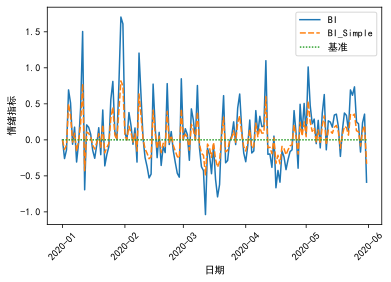

In [12]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['axes.unicode_minus'] = False  
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

df = pd.read_csv('merged_sentiment_idx.csv', parse_dates=['time'])
df.set_index(df.time, inplace=True)
df = df.loc['2020-1':'2020-5']
df['基准'] = 0
sns.lineplot(data=df[['BI','BI_Simple','基准']])
plt.xticks(rotation=45)
plt.xlabel('日期')
plt.ylabel('情绪指标')
plt.savefig('./图片1.png', dpi=1000, bbox_inches='tight')
plt.show()

## 结果绘图

Text(0.5, 0, '日期')

Text(0, 0.5, '10天EWMA')

Text(0, 0.5, '华东医药')

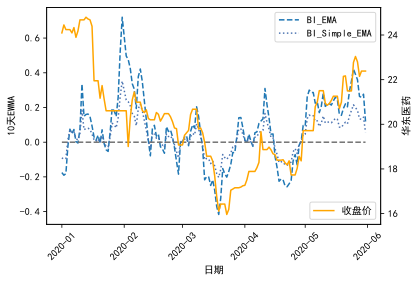

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['axes.unicode_minus'] = False  
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

df = pd.read_csv('merged_sentiment_idx.csv', parse_dates=['time'])
df['BI_EMA'] = df['BI'].ewm(span=10).mean()
df['BI_Simple_EMA'] = df['BI_Simple'].ewm(span=10).mean()
df['情绪临界'] = 0 
df.set_index(df.time, inplace=True)
df = df.loc['2020-1':'2020-5']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df.index, df['BI_EMA'], color='#1F77B4', linestyle='--', label='BI_EMA')
ax1.plot(df.index, df['BI_Simple_EMA'], color='#4B73B1', linestyle=':', label='BI_Simple_EMA')
ax1.plot(df.index, df['情绪临界'], color='#6E6E6E', linestyle='--')
ax2.plot(df.index, df['close'], color='#FFA500',label='收盘价')
ax1.set_xlabel('日期')
ax1.set_ylabel('10天EWMA')
ax2.set_ylabel('华东医药')
ax1.legend()
ax2.legend(loc=4)

# 坐标倾斜
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

plt.savefig('./图片2.png', dpi=1000, bbox_inches='tight')
plt.show()

## 股吧避雷

In [14]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all' #默认为'last'

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['axes.unicode_minus'] = False  
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
import seaborn as sns
import pandas as pd
import numpy as np

result = pd.read_csv('./merged_sentiment_idx.csv', parse_dates=['time']).set_index('time')
result = result.dropna()
result = result[['BI','close']]
result.index = pd.to_datetime(result.index)
result

,BI,close
time,,
2014-01-02,1.098612,12.3128
2014-01-03,-0.693147,12.3886
2014-01-04,0.000000,12.3886
2014-01-06,0.000000,12.1863
2014-01-07,0.693147,12.0650
...,...,...
2021-03-30,-0.031952,36.8600
2021-03-31,0.102479,36.8800
2021-04-01,0.458811,38.8000


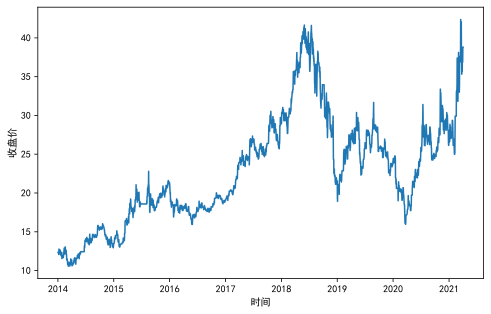

In [15]:
fig = plt.figure(figsize=(8,5),dpi=500)
fig = sns.lineplot(data=result['close'])
fig = plt.ylabel('收盘价')
fig = plt.xlabel('时间')

In [16]:
# 针对情绪构造指标来进行分析

# 1、前10天的情绪的平均数
result['BI_MA'] = result['BI'].rolling(window=10, center=False).mean()
# 2、前10天的情绪的标准差
result['BI_STD'] = result['BI'].rolling(window=10, center=False).std()
# 3、前10天情绪的极差
result['BI_RANGE'] = result['BI'].rolling(window=10, center=False).max() - result['BI'].rolling(window=10, center=False).min()
# 4、前10天情绪的累计
result['BI_CULMULATE'] = result['BI'].rolling(window=10, center=False).sum()
# 5、前10天情绪的加权平均
result['BI_EMA'] = result['BI'].ewm(span=10).mean()

In [17]:
result

,BI,close,BI_MA,BI_STD,BI_RANGE,BI_CULMULATE,BI_EMA
time,,,,,,,
2014-01-02,1.098612,12.3128,NaN,NaN,NaN,NaN,1.098612
2014-01-03,-0.693147,12.3886,NaN,NaN,NaN,NaN,0.113145
2014-01-04,0.000000,12.3886,NaN,NaN,NaN,NaN,0.067661
2014-01-06,0.000000,12.1863,NaN,NaN,NaN,NaN,0.045370
2014-01-07,0.693147,12.0650,NaN,NaN,NaN,NaN,0.231329
...,...,...,...,...,...,...,...
2021-03-30,-0.031952,36.8600,0.053404,0.262521,0.811877,0.534038,0.123754
2021-03-31,0.102479,36.8800,0.044546,0.258828,0.811877,0.445461,0.119886
2021-04-01,0.458811,38.8000,0.073767,0.288888,0.817756,0.737668,0.181509


In [18]:
quotes = pd.read_excel('./data/stock_data.xlsx', parse_dates=['trade_date'], index_col=0)
quotes.set_index('trade_date', drop=True, inplace=True)
quotes = quotes[::-1]

In [19]:
df = pd.merge(result, quotes, how='left', left_index=True, right_index=True).loc[:,'ts_code':].fillna(method='ffill')
df.rename(columns={'close_y':'close'}, inplace=True)
df

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
time,,,,,,,,,,
2014-01-02,000963.SZ,11.5214,12.5605,11.5214,12.3128,11.6301,0.6827,5.8701,33531.39,1.634881e+05
2014-01-03,000963.SZ,12.3077,12.6389,12.1509,12.3886,12.3128,0.0758,0.6156,25785.24,1.261462e+05
2014-01-04,000963.SZ,12.3077,12.6389,12.1509,12.3886,12.3128,0.0758,0.6156,25785.24,1.261462e+05
2014-01-06,000963.SZ,12.6162,12.6414,12.1358,12.1863,12.3886,-0.2023,-1.6330,23506.67,1.147619e+05
2014-01-07,000963.SZ,11.9841,12.6414,11.8248,12.0650,12.1863,-0.1213,-0.9954,12978.91,6.269529e+04
...,...,...,...,...,...,...,...,...,...,...
2021-03-30,000963.SZ,36.6500,38.7000,36.4100,36.8600,37.0500,-0.1900,-0.5128,661329.43,2.476063e+06
2021-03-31,000963.SZ,36.3000,38.0700,36.2200,36.8800,36.8600,0.0200,0.0543,454457.38,1.686294e+06
2021-04-01,000963.SZ,37.4200,39.4800,36.9200,38.8000,36.8800,1.9200,5.2061,778111.63,2.987827e+06


In [20]:
# 针对价格构造指标来进行分析
df['收益率'] = df['close'].diff() / df['close'].shift()
df['最高价-最低价'] = (df['high'] - df['low']) / df['low']

# 6、前10天收益率累计
df['前10天收益率累计'] = df['收益率'].rolling(window=10, center=False).sum()
# 7、前10天收益率均值
df['前10天收益率均值'] = df['收益率'].rolling(window=10, center=False).mean()
# 8、前10天收益率加权平均
df['前10天收益率加权平均'] = df['收益率'].ewm(span=10).mean()
# 9、前10天收益率标准差
df['前10天收益率标准差'] = df['收益率'].rolling(window=10, center=False).std()
# 10、前10天收益率极差
df['前10天收益率极差'] = df['收益率'].rolling(window=10, center=False).max() - df['收益率'].rolling(window=10, center=False).min()
# 11、前10天每天最高价与最低价涨幅的标准差
df['前10天每天最高价与最低价涨幅的标准差'] = df['最高价-最低价'].rolling(window=10, center=False).std()
# 12、前10天最高价的最大值与最低价的最小值的差额
df['前10天最高价的最大值与最低价的最小值的涨幅'] = (df['high'].rolling(window=10, center=False).max()\
                                                - df['low'].rolling(window=10, center=False).min())\
                                                / df['low'].rolling(window=10, center=False).min()
# 13、前10天成交量的均值
df['前10天成交量的均值'] = df['vol'].rolling(window=10, center=False).mean()
# 14、前10天成交量的加权平均
df['前10天成交量的加权平均'] = df['vol'].ewm(span=10).mean()
# 15、前10天成交量的标准差
df['前10天成交量的标准差'] = df['vol'].rolling(window=10, center=False).std()
# 16、前10天成交量的极差比
df['前10天成交量的极差比'] = (df['vol'].rolling(window=10, center=False).max() - df['vol'].rolling(window=10, center=False).min())\
                          /df['vol'].rolling(window=10, center=False).min()

In [21]:
df

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,前10天收益率均值,前10天收益率加权平均,前10天收益率标准差,前10天收益率极差,前10天每天最高价与最低价涨幅的标准差,前10天最高价的最大值与最低价的最小值的涨幅,前10天成交量的均值,前10天成交量的加权平均,前10天成交量的标准差,前10天成交量的极差比
time,,,,,,,,,,,,,,,,,,,,,
2014-01-02,000963.SZ,11.5214,12.5605,11.5214,12.3128,11.6301,0.6827,5.8701,33531.39,1.634881e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33531.390000,NaN,NaN
2014-01-03,000963.SZ,12.3077,12.6389,12.1509,12.3886,12.3128,0.0758,0.6156,25785.24,1.261462e+05,...,NaN,0.006156,NaN,NaN,NaN,NaN,NaN,29271.007500,NaN,NaN
2014-01-04,000963.SZ,12.3077,12.6389,12.1509,12.3886,12.3128,0.0758,0.6156,25785.24,1.261462e+05,...,NaN,0.002770,NaN,NaN,NaN,NaN,NaN,27869.752126,NaN,NaN
2014-01-06,000963.SZ,12.6162,12.6414,12.1358,12.1863,12.3886,-0.2023,-1.6330,23506.67,1.147619e+05,...,NaN,-0.004908,NaN,NaN,NaN,NaN,NaN,26432.310960,NaN,NaN
2014-01-07,000963.SZ,11.9841,12.6414,11.8248,12.0650,12.1863,-0.1213,-0.9954,12978.91,6.269529e+04,...,NaN,-0.006570,NaN,NaN,NaN,NaN,NaN,22570.205444,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30,000963.SZ,36.6500,38.7000,36.4100,36.8600,37.0500,-0.1900,-0.5128,661329.43,2.476063e+06,...,-0.011557,-0.000962,0.042366,0.139342,0.043183,0.279472,727586.255,684235.815276,210812.338827,1.227911
2021-03-31,000963.SZ,36.3000,38.0700,36.2200,36.8800,36.8600,0.0200,0.0543,454457.38,1.686294e+06,...,-0.011503,-0.000689,0.042383,0.139342,0.043839,0.279472,678685.718,642457.917953,211885.890646,1.561795
2021-04-01,000963.SZ,37.4200,39.4800,36.9200,38.8000,36.8800,1.9200,5.2061,778111.63,2.987827e+06,...,-0.007039,0.008902,0.046726,0.152132,0.043729,0.229912,675587.089,667122.229234,209984.875228,1.561795


In [22]:
result = pd.concat([result,df.loc[:,'前10天收益率累计':]], axis=1)
result

,BI,close,BI_MA,BI_STD,BI_RANGE,BI_CULMULATE,BI_EMA,前10天收益率累计,前10天收益率均值,前10天收益率加权平均,前10天收益率标准差,前10天收益率极差,前10天每天最高价与最低价涨幅的标准差,前10天最高价的最大值与最低价的最小值的涨幅,前10天成交量的均值,前10天成交量的加权平均,前10天成交量的标准差,前10天成交量的极差比
time,,,,,,,,,,,,,,,,,,
2014-01-02,1.098612,12.3128,NaN,NaN,NaN,NaN,1.098612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33531.390000,NaN,NaN
2014-01-03,-0.693147,12.3886,NaN,NaN,NaN,NaN,0.113145,NaN,NaN,0.006156,NaN,NaN,NaN,NaN,NaN,29271.007500,NaN,NaN
2014-01-04,0.000000,12.3886,NaN,NaN,NaN,NaN,0.067661,NaN,NaN,0.002770,NaN,NaN,NaN,NaN,NaN,27869.752126,NaN,NaN
2014-01-06,0.000000,12.1863,NaN,NaN,NaN,NaN,0.045370,NaN,NaN,-0.004908,NaN,NaN,NaN,NaN,NaN,26432.310960,NaN,NaN
2014-01-07,0.693147,12.0650,NaN,NaN,NaN,NaN,0.231329,NaN,NaN,-0.006570,NaN,NaN,NaN,NaN,NaN,22570.205444,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-30,-0.031952,36.8600,0.053404,0.262521,0.811877,0.534038,0.123754,-0.115575,-0.011557,-0.000962,0.042366,0.139342,0.043183,0.279472,727586.255,684235.815276,210812.338827,1.227911
2021-03-31,0.102479,36.8800,0.044546,0.258828,0.811877,0.445461,0.119886,-0.115032,-0.011503,-0.000689,0.042383,0.139342,0.043839,0.279472,678685.718,642457.917953,211885.890646,1.561795
2021-04-01,0.458811,38.8000,0.073767,0.288888,0.817756,0.737668,0.181509,-0.070395,-0.007039,0.008902,0.046726,0.152132,0.043729,0.229912,675587.089,667122.229234,209984.875228,1.561795


In [23]:
# 每隔5天计算一次涨跌幅
result['close_diff'] = result['close'].diff(5).shift(-5) / result['close']
result['close_diff'].describe()
result['close_diff_binary'] = np.where(result['close_diff'] > 0, 1, 0)
result = result.reindex(columns=sorted(result.columns.to_list()))
result.dropna(inplace=True)
result

count    2388.000000
mean        0.003388
std         0.045185
min        -0.246939
25%        -0.020181
50%         0.001210
75%         0.026463
max         0.197598
Name: close_diff, dtype: float64

,BI,BI_CULMULATE,BI_EMA,BI_MA,BI_RANGE,BI_STD,close,close_diff,close_diff_binary,前10天成交量的加权平均,前10天成交量的均值,前10天成交量的极差比,前10天成交量的标准差,前10天收益率加权平均,前10天收益率均值,前10天收益率极差,前10天收益率标准差,前10天收益率累计,前10天最高价的最大值与最低价的最小值的涨幅,前10天每天最高价与最低价涨幅的标准差
time,,,,,,,,,,,,,,,,,,,,
2014-01-15,0.693147,3.267666,0.499645,0.326767,1.945910,0.609719,12.6263,-0.038847,0,14543.447639,16683.071,1.866555,6172.869428,0.004078,0.002790,0.088091,0.024830,0.027900,0.111182,0.017909
2014-01-16,-0.405465,3.555348,0.318805,0.355535,1.658228,0.561098,12.6414,-0.060001,0,15369.305853,15972.238,1.866555,5364.615868,0.003489,0.002294,0.088091,0.024805,0.022939,0.111182,0.017704
2014-01-17,-0.693147,2.862201,0.120190,0.286220,1.945910,0.646251,12.4392,-0.007316,0,14321.487942,14396.777,1.613246,4386.834526,-0.000404,0.000694,0.088091,0.025476,0.006944,0.111182,0.018335
2014-01-20,0.000000,2.862201,0.096937,0.286220,1.945910,0.646251,12.0549,0.024330,1,15047.522253,13853.522,1.076320,3346.312988,-0.006388,-0.000762,0.089145,0.026932,-0.007620,0.111182,0.018206
2014-01-21,-0.405465,1.763589,0.000855,0.176359,1.945910,0.662563,11.9386,-0.032190,0,14402.269062,13722.986,1.076320,3409.092920,-0.007019,-0.000731,0.089145,0.026921,-0.007314,0.115237,0.017885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,-0.158941,1.298162,0.074291,0.129816,0.900854,0.273032,35.3200,0.043601,1,848862.604018,854594.738,1.411312,218336.285420,-0.018091,-0.003581,0.200019,0.055618,-0.035815,0.279472,0.041757
2021-03-26,-0.358945,0.988007,-0.004479,0.098801,1.030958,0.310606,35.6500,0.034502,1,789535.619651,858569.278,1.227911,211057.012147,-0.013103,-0.002055,0.200019,0.055756,-0.020546,0.279472,0.042233
2021-03-27,0.259511,1.024375,0.043519,0.102437,1.030958,0.312431,35.6500,0.088359,1,740995.359715,847904.713,1.227911,226092.876512,-0.010721,-0.006417,0.200019,0.053444,-0.064166,0.279472,0.042058


In [24]:
print("样本中类别为1的比例:{:.5f}".format(sum(result['close_diff_binary']==1) / len(result['close_diff_binary'])))

样本中类别为1的比例:0.51388


In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, recall_score
from sklearn.preprocessing import StandardScaler
import random
import numpy as np

In [26]:
X_train = pd.concat([result.loc[:'2019-12-31','BI':'BI_STD'], result.loc[:'2019-12-31','close_diff_binary':].iloc[:,1:]],axis=1)
y_train = result.loc[:'2019-12-31','close_diff_binary']
X_test = pd.concat([result.loc['2020-01-01':,'BI':'BI_STD'], result.loc['2020-01-01':,'close_diff_binary':].iloc[:,1:]],axis=1)
y_test = result.loc['2020-01-01':,'close_diff_binary']

In [27]:
X_train

,BI,BI_CULMULATE,BI_EMA,BI_MA,BI_RANGE,BI_STD,前10天成交量的加权平均,前10天成交量的均值,前10天成交量的极差比,前10天成交量的标准差,前10天收益率加权平均,前10天收益率均值,前10天收益率极差,前10天收益率标准差,前10天收益率累计,前10天最高价的最大值与最低价的最小值的涨幅,前10天每天最高价与最低价涨幅的标准差
time,,,,,,,,,,,,,,,,,
2014-01-15,0.693147,3.267666,0.499645,0.326767,1.945910,0.609719,14543.447639,16683.071,1.866555,6172.869428,0.004078,0.002790,0.088091,0.024830,0.027900,0.111182,0.017909
2014-01-16,-0.405465,3.555348,0.318805,0.355535,1.658228,0.561098,15369.305853,15972.238,1.866555,5364.615868,0.003489,0.002294,0.088091,0.024805,0.022939,0.111182,0.017704
2014-01-17,-0.693147,2.862201,0.120190,0.286220,1.945910,0.646251,14321.487942,14396.777,1.613246,4386.834526,-0.000404,0.000694,0.088091,0.025476,0.006944,0.111182,0.018335
2014-01-20,0.000000,2.862201,0.096937,0.286220,1.945910,0.646251,15047.522253,13853.522,1.076320,3346.312988,-0.006388,-0.000762,0.089145,0.026932,-0.007620,0.111182,0.018206
2014-01-21,-0.405465,1.763589,0.000855,0.176359,1.945910,0.662563,14402.269062,13722.986,1.076320,3409.092920,-0.007019,-0.000731,0.089145,0.026921,-0.007314,0.115237,0.017885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.000000,-2.056800,-0.259835,-0.205680,1.460402,0.445661,114428.487944,118546.002,2.150862,40289.954074,0.001105,-0.000788,0.036457,0.010043,-0.007881,0.048189,0.005043
2019-12-28,-0.510826,-2.344482,-0.305469,-0.234448,1.460402,0.456077,118269.951954,111904.704,1.482176,28864.299845,0.000904,0.000956,0.031076,0.008170,0.009558,0.048189,0.005097
2019-12-29,0.223144,-2.251391,-0.209358,-0.225139,1.460402,0.465202,121412.967963,109549.664,1.114774,25329.443515,0.000739,-0.000946,0.020933,0.005156,-0.009461,0.048189,0.004888


In [28]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler()

In [29]:
def true_f_lambda(y_true, y_pred): 
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    r_f = p_f = r_p = p_p = 0
    if (tn + fp) != 0 :
        r_f = tn / (tn + fp)
    if (tn + fn) != 0:
        p_f = tn / (tn + fn)
    if (tp + fn) != 0:
        r_p = tp / (tp + fn)
    if (tp + fp) != 0:
        p_p = tp / (tp + fp)
    #r_f * pow(np.exp(10*p_f), 1/(p_f*10-1))
    return 5*r_f*p_f / (4*p_f+r_f) * 5 + 2*r_p*p_p / (r_p+p_p)

parameters = {
    "n_estimators":np.arange(50,300,20),
    "learning_rate":[1e-2,0.1,0.5,1,1.25,1.5,1.75,2,2.5,3],
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=0).set_params(ccp_alpha=a) for a in np.logspace(-15,0,15)]
}

clf = AdaBoostClassifier()
grid = GridSearchCV(clf, parameters, cv = StratifiedShuffleSplit(n_splits=3,test_size=0.2,random_state=0)
                    , scoring = make_scorer(true_f_lambda), verbose=1, refit=True, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 1950 candidates, totalling 5850 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 5850 out of 5850 | elapsed: 10.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=0, test_size=0.2,
            train_size=None),
             estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'base_estimator': [DecisionTreeClassifier(ccp_alpha=1e-15,
                                                                   max_depth=1,
                                                                   random_state=0),
                                            DecisionTreeClassifier(ccp_alpha=1.1787686347935866e-14,
                                                                   max_depth=1,
                                                                   random_state=0),
                                            DecisionTreeClassifier(ccp_alpha...
                                            DecisionTreeClassifier(ccp_alpha=0.007196856730011528,
                                                                   max_depth=1,
                                                            

In [30]:
best_estimator = grid.best_estimator_
print(best_estimator)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=1e-15,
                                                         max_depth=1,
                                                         random_state=0),
                   learning_rate=2)


In [31]:
model = grid.best_estimator_
y_predict = model.predict(X_test)
y_predict_train = model.predict(X_train)

model_base = AdaBoostClassifier()
model_base.fit(X_train, y_train)
y_predict_base = model_base.predict(X_test)
print('----------------------------------------------------------------------------------')
print('----------------------------------训练集---------------------------------------')
print(classification_report(y_train, y_predict_train))
print('----------------------------------------------------------------------------------')
print('----------------------------------测试集---------------------------------------')
print("基础的AdaBoost模型")
print(classification_report(y_test, y_predict_base))
print('----------------------------------------------------------------------------------')
print("调参后的AdaBoost模型")
print(classification_report(y_test, y_predict))
print('----------------------------------------------------------------------------------')
print("随机分类器1")
print(classification_report(y_test, np.random.randint(0,2,size=len(y_test))))
print('----------------------------------------------------------------------------------')
print("随机分类器2")
print(classification_report(y_test, np.random.randint(0,2,size=len(y_test))))
print('----------------------------------------------------------------------------------')
print("随机分类器3")
print(classification_report(y_test, np.random.randint(0,2,size=len(y_test))))
print('----------------------------------------------------------------------------------')
print("随机分类器4")
print(classification_report(y_test, np.random.randint(0,2,size=len(y_test))))
print('----------------------------------------------------------------------------------')
print("随机分类器5")
print(classification_report(y_test, np.random.randint(0,2,size=len(y_test))))
print('----------------------------------------------------------------------------------')

AdaBoostClassifier()

----------------------------------------------------------------------------------
----------------------------------训练集---------------------------------------
              precision    recall  f1-score   support

           0       0.48      0.91      0.63       934
           1       0.48      0.08      0.14       991

    accuracy                           0.48      1925
   macro avg       0.48      0.49      0.38      1925
weighted avg       0.48      0.48      0.38      1925

----------------------------------------------------------------------------------
----------------------------------测试集---------------------------------------
基础的AdaBoost模型
              precision    recall  f1-score   support

           0       0.50      0.75      0.60       222
           1       0.54      0.28      0.37       231

    accuracy                           0.51       453
   macro avg       0.52      0.51      0.48       453
weighted avg       0.52      0.51      0.48       453

------------

In [32]:
data = model.predict(X_test)
data = pd.DataFrame(data, index=result.loc['2020-01-01':,:].index, columns=['预测未来5天收益正负'])
data

,预测未来5天收益正负
time,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,1
...,...
2021-03-25,0
2021-03-26,0
2021-03-27,0


In [33]:
# 正确的看跌点
point1 = result.loc['2020-01-01':,'close'][data['预测未来5天收益正负']==0][data['预测未来5天收益正负']==result.loc['2020-01-01':,'close_diff_binary']]
# 未标记的看跌点
point2 = result.loc['2020-01-01':,'close'][data['预测未来5天收益正负']==1][data['预测未来5天收益正负']!=result.loc['2020-01-01':,'close_diff_binary']]
# 错误标记的看跌点
point3 = result.loc['2020-01-01':,'close'][data['预测未来5天收益正负']==0][data['预测未来5天收益正负']!=result.loc['2020-01-01':,'close_diff_binary']]

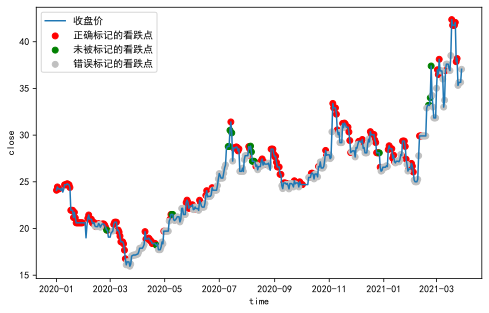

In [34]:
fig = plt.figure(figsize=(8,5),dpi=500)
fig = sns.lineplot(data=result.loc['2020-01-01':,'close'], label='收盘价')
point = result.loc['2020-01-01':,'close'][[x[0] for x in list((data==0).values)]]
fig = plt.scatter(x=point1.index,y=point1, color ='red', label='正确标记的看跌点')
fig = plt.scatter(x=point2.index,y=point2, color ='green', label='未被标记的看跌点')
fig = plt.scatter(x=point3.index,y=point3, color ='silver', label='错误标记的看跌点')
plt.legend()
plt.savefig('./图片3.png',bbox_inches="tight", dpi=1000)

In [35]:
(data==0).sum() / len(data)

预测未来5天收益正负    0.891832
dtype: float64